# Predicting Energy Consumption with XGBoost

Regression analysis can be used to model the relationship between a dependent variable and one or more independent variables. 
- In the context of time series analysis, regression can be used to model the relationship between a time series variable and one or more predictor variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Lets read and show the data

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


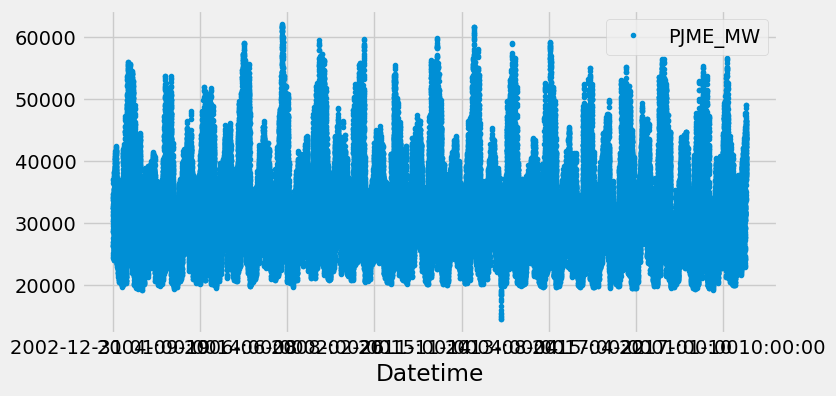

In [3]:
df.plot(figsize=(8,4), style='.')
plt.show()

In [4]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

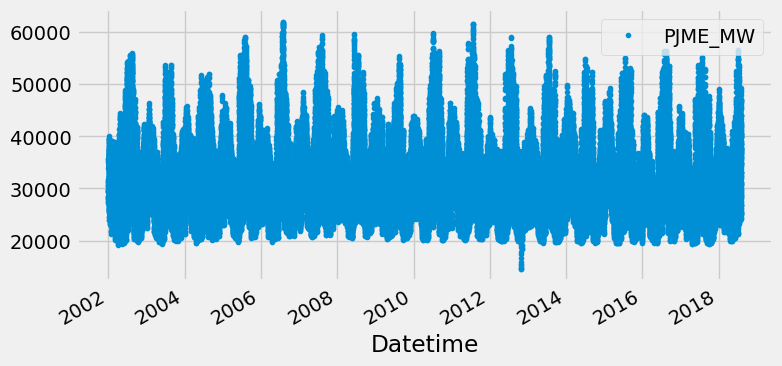

In [5]:
df.index = pd.to_datetime(df.index)
df.plot(figsize=(8,4), style='.')
plt.show()

<Axes: xlabel='Datetime'>

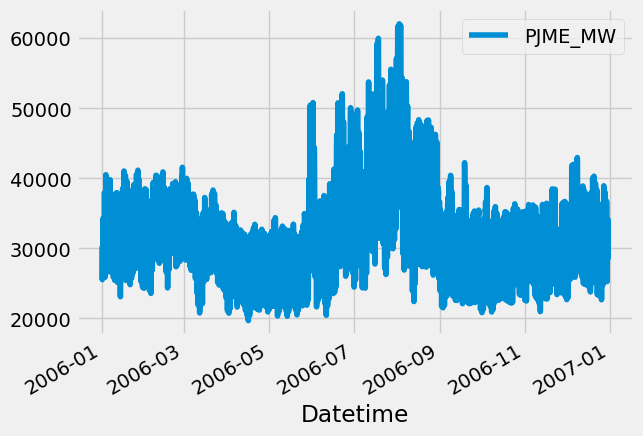

In [6]:
df[(df.index >= '2006-01-01') & (df.index <= '2006-12-31')].plot()

<Axes: xlabel='Datetime'>

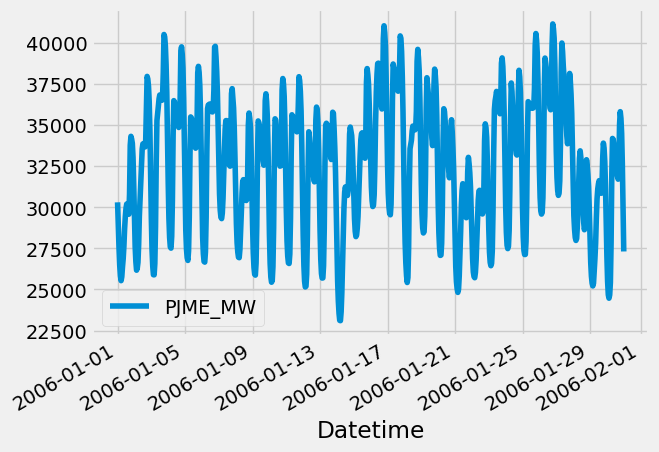

In [7]:
df[(df.index >= '2006-01-01') & (df.index <= '2006-01-31')].plot()

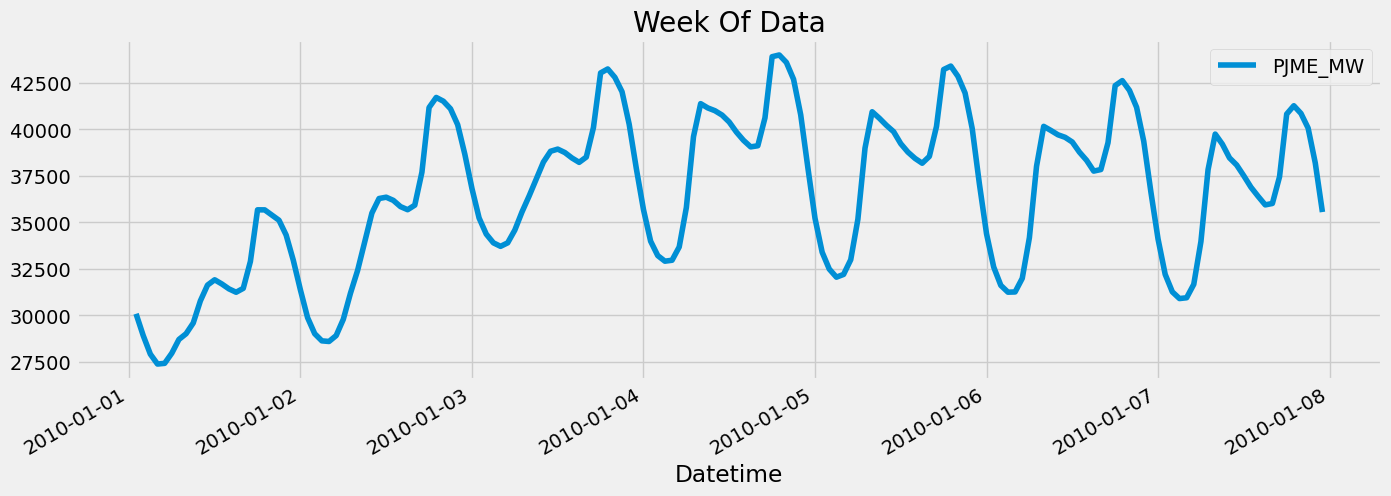

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Train / Test Split

Unlike traditional train/test splitting, where the data is randomly divided into training and testing sets, in time series analysis, the data is split in chronological order, such that the training set includes data from earlier time periods and the testing set includes data from later time periods.

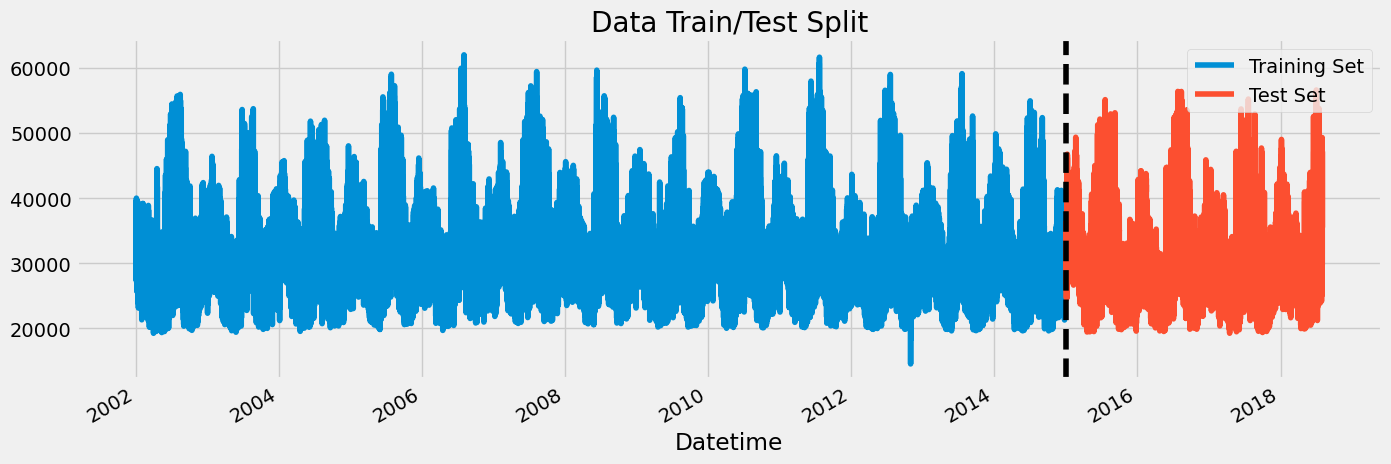

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Now, lets create some features that are relevant to the forecasting, and that are related to the date

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


### Visualize our Feature / Target Relationship

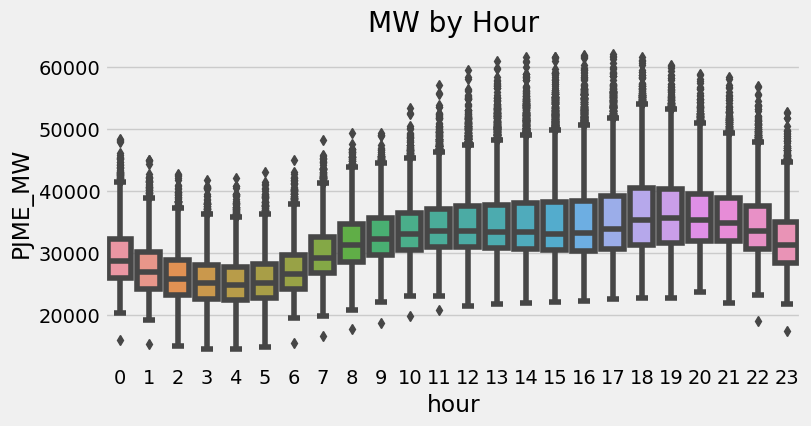

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

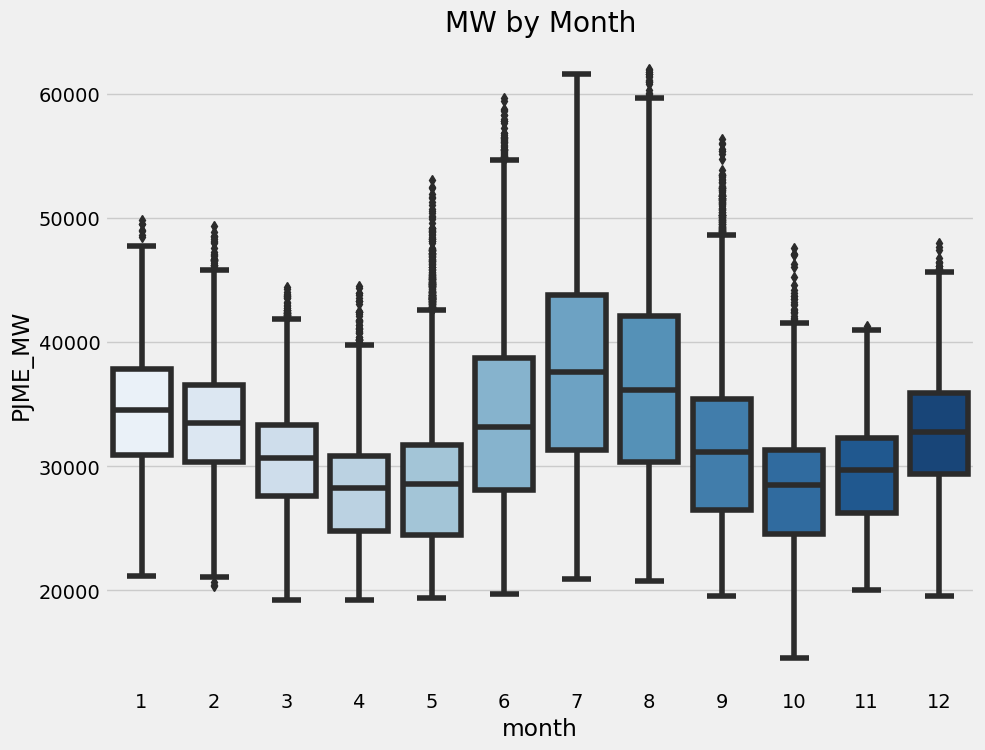

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Create our Model

In [13]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

We will use XGB regressor, a very powerfull classifier based on decision trees and boosting

In [14]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=True)

[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[1]	validation_0-rmse:16420.93235	validation_1-rmse:15523.28748
[2]	validation_0-rmse:11738.22738	validation_1-rmse:10902.11140
[3]	validation_0-rmse:8540.54141	validation_1-rmse:7809.80731
[4]	validation_0-rmse:6406.33278	validation_1-rmse:5886.97003
[5]	validation_0-rmse:5020.18414	validation_1-rmse:4712.54530
[6]	validation_0-rmse:4115.48568	validation_1-rmse:4193.11193
[7]	validation_0-rmse:3582.20742	validation_1-rmse:3953.68877
[8]	validation_0-rmse:3261.69940	validation_1-rmse:3796.80086
[9]	validation_0-rmse:3081.02460	validation_1-rmse:3777.59061
[10]	validation_0-rmse:2982.98557	validation_1-rmse:3763.35259
[11]	validation_0-rmse:2888.50281	validation_1-rmse:3809.64469
[12]	validation_0-rmse:2840.45869	validation_1-rmse:3810.92832
[13]	validation_0-rmse:2794.92469	validation_1-rmse:3833.23047
[14]	validation_0-rmse:2768.03577	validation_1-rmse:3826.70942
[15]	validation_0-rmse:2747.60912	validation_1-rmse:3839.66

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

You can see that the error in the validation set starts to increase, so we have overfit the model.

Lets try with a small learning rate to move slower ..

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=100)

[0]	validation_0-rmse:32894.63731	validation_1-rmse:31946.77347
[100]	validation_0-rmse:29802.40434	validation_1-rmse:28850.26957
[200]	validation_0-rmse:27007.68441	validation_1-rmse:26052.43931
[300]	validation_0-rmse:24482.32005	validation_1-rmse:23533.89183
[400]	validation_0-rmse:22201.28055	validation_1-rmse:21261.74073
[500]	validation_0-rmse:20141.56473	validation_1-rmse:19212.14293
[600]	validation_0-rmse:18281.64247	validation_1-rmse:17373.31404
[700]	validation_0-rmse:16603.51761	validation_1-rmse:15718.16953
[800]	validation_0-rmse:15090.22011	validation_1-rmse:14218.31995
[900]	validation_0-rmse:13726.67411	validation_1-rmse:12872.89007
[999]	validation_0-rmse:12510.64305	validation_1-rmse:11682.68908


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Lets move now a little faster in order to find a better solution

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12341.93072	validation_1-rmse:11522.06347
[200]	validation_0-rmse:5373.23326	validation_1-rmse:5164.82201
[300]	validation_0-rmse:3377.06238	validation_1-rmse:3829.91316
[400]	validation_0-rmse:2877.98846	validation_1-rmse:3713.12414
[440]	validation_0-rmse:2785.25298	validation_1-rmse:3725.51793


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [17]:
reg.feature_importances_

array([0.08809143, 0.36828476, 0.13760343, 0.02435163, 0.36282027,
       0.01884845], dtype=float32)

Values are meaningless, so lets improve the visualization by creating a new dataframe

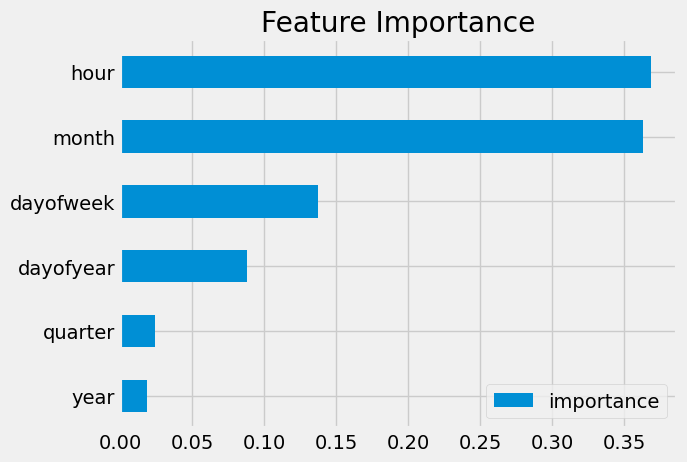

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Lets see the correlations between features ...

<Axes: >

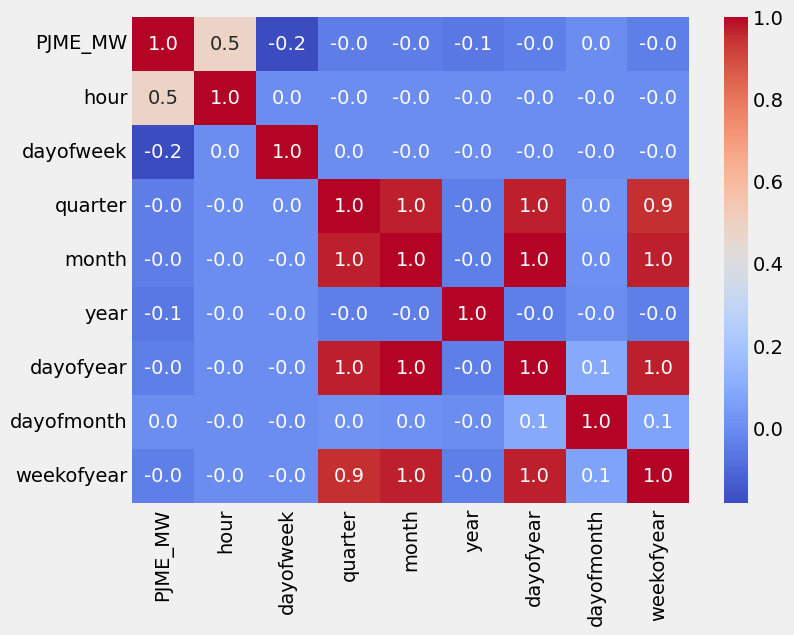

In [19]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')

## Forecast on Test

In [20]:
y_pred = reg.predict(X_test)
y_pred

array([31969.053, 28255.934, 27129.057, ..., 34896.535, 33256.477,
       31969.053], dtype=float32)

For a better visualization, lets add the predicted values to the original dataset

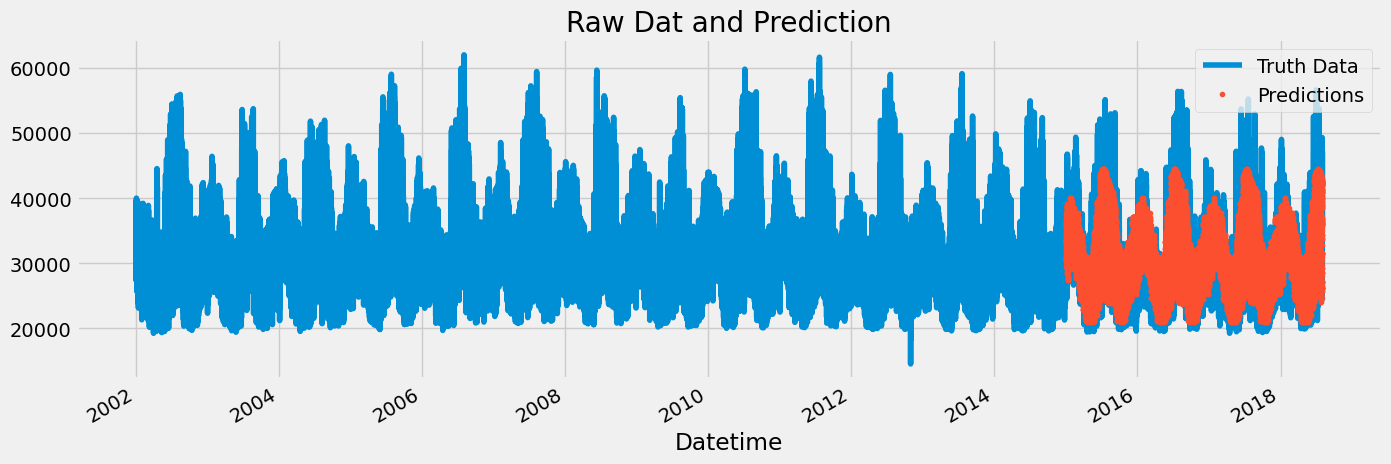

In [21]:
test['prediction'] = y_pred
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In a week ..

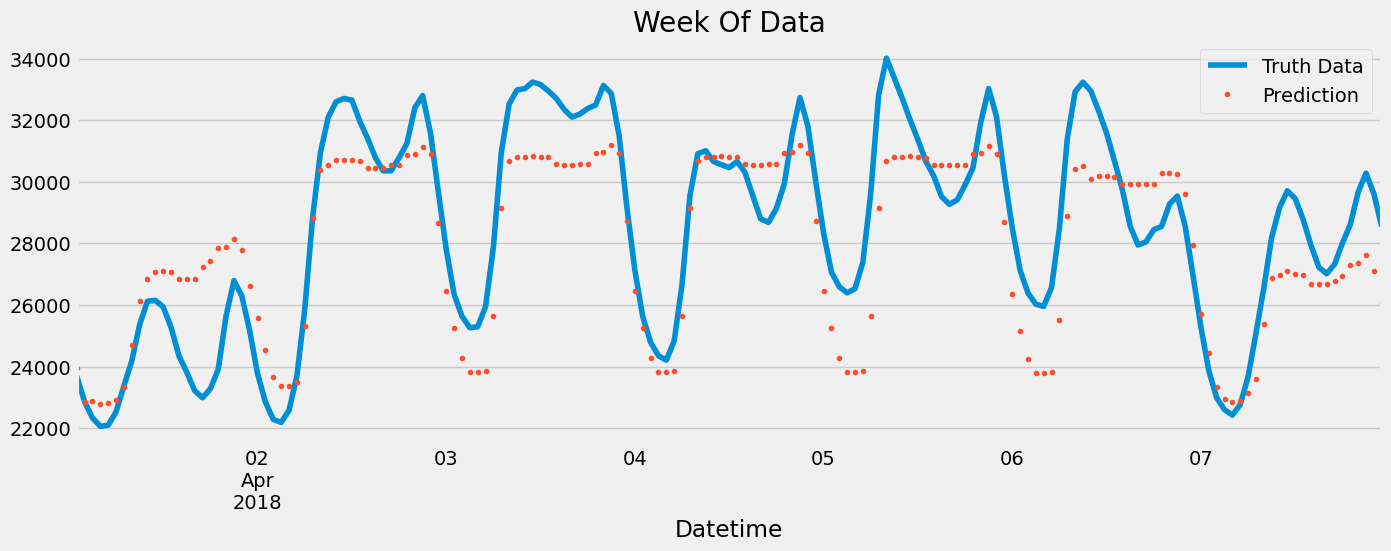

In [22]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Results are not as good as they can be, but the regressor have managed to capture the seasonality.

## Score (RMSE)

In [23]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3712.34


Look at the worst predicted days ... where they hollidays?

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14650.704508
2016-08-14    14538.611247
2016-09-10    12576.863607
2016-09-09    11522.881266
2016-08-12    11510.995850
2015-02-20    10841.270915
2018-01-06    10807.138916
2016-08-11    10404.905436
2017-05-19    10211.232259
2015-02-16    10126.586426
Name: error, dtype: float64

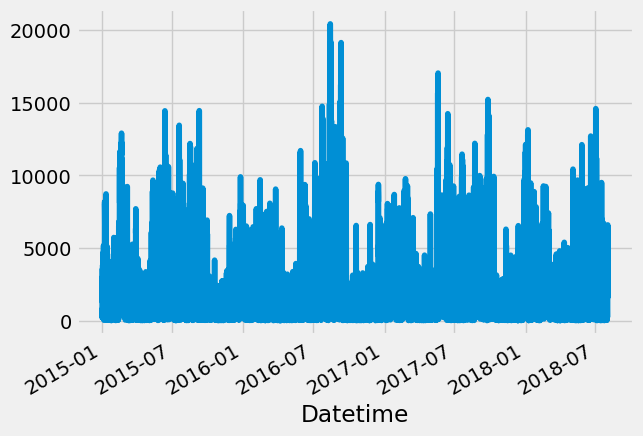

In [25]:
test.error.plot()
ax.set_title('Errors per day')
plt.show()

Lets zoom the errors in a year

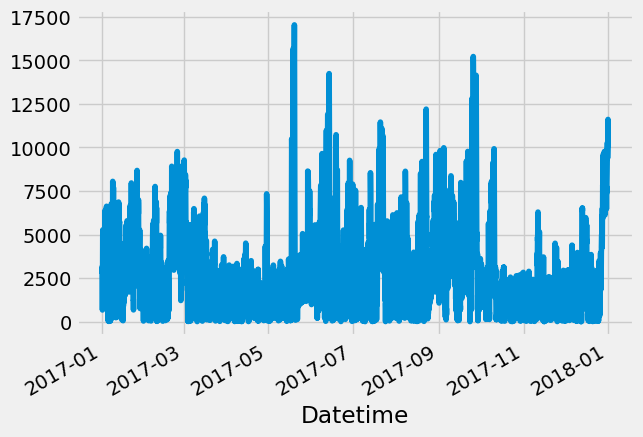

In [26]:
test.error.loc[(test.index > '01-01-2017') & (test.index < '01-01-2018')].plot()
ax.set_title('Errors per day in a year')
plt.show()

And zoom in a week

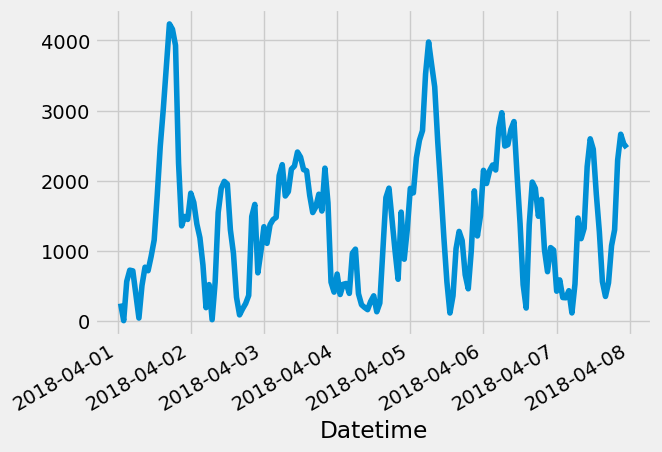

In [27]:
test.error.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')].plot()
ax.set_title('Errors per day in a week')
plt.show()

Plenty of room to improve:
- More robust cross validation
- Add more features (weather forecast, holidays)

## Outlier Analysis and removal

<Axes: ylabel='Frequency'>

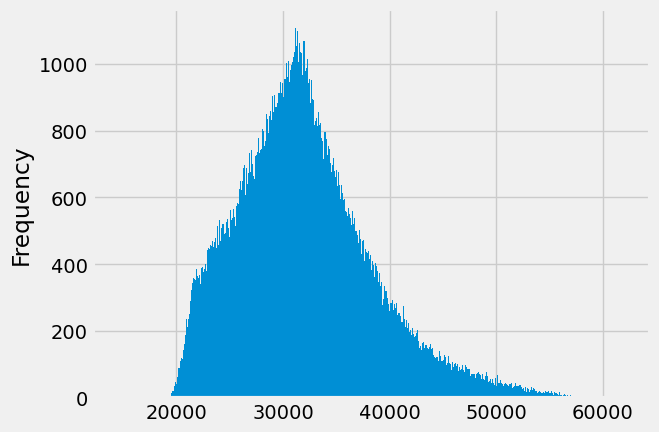

In [28]:
df['PJME_MW'].plot(kind='hist', bins=500)

Lets first consider those points with largest values

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

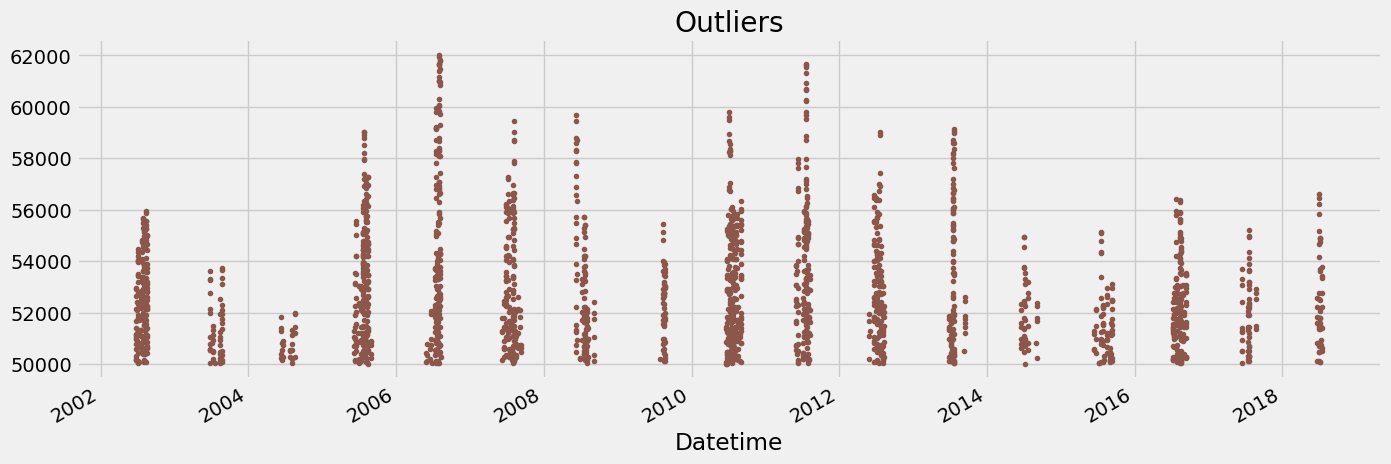

In [29]:
df.query('PJME_MW > 50_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

They are consistent with the times of the year where the demand is higher.

Now, lets see the days with lowest consumption

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

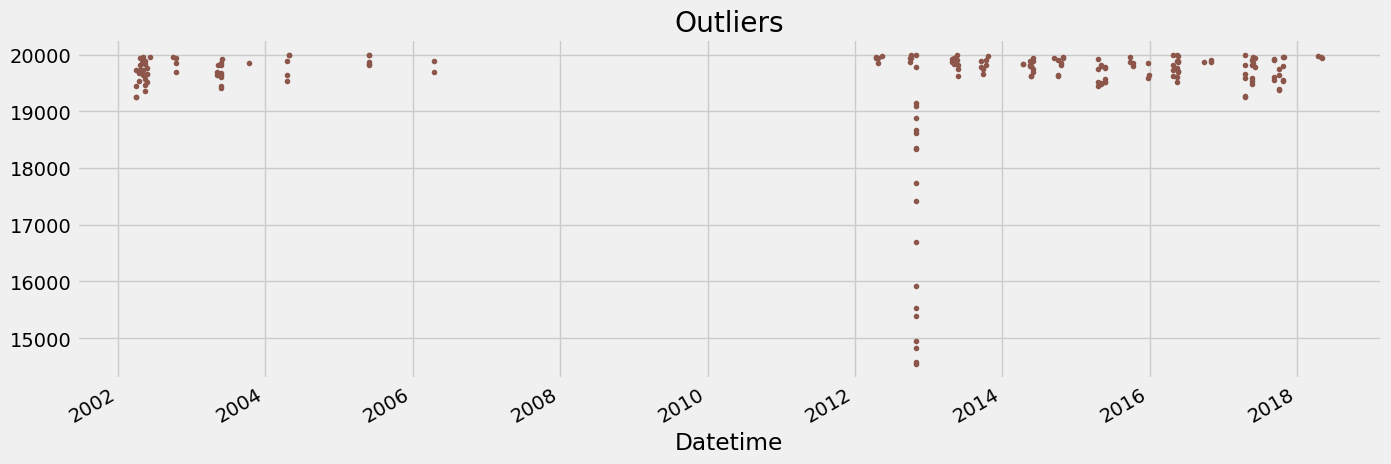

In [30]:
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

Most of the points are consistent, but some of them have a nasty behavior. 
- Maybe they are real values, but not usefull for predicting in the future.

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

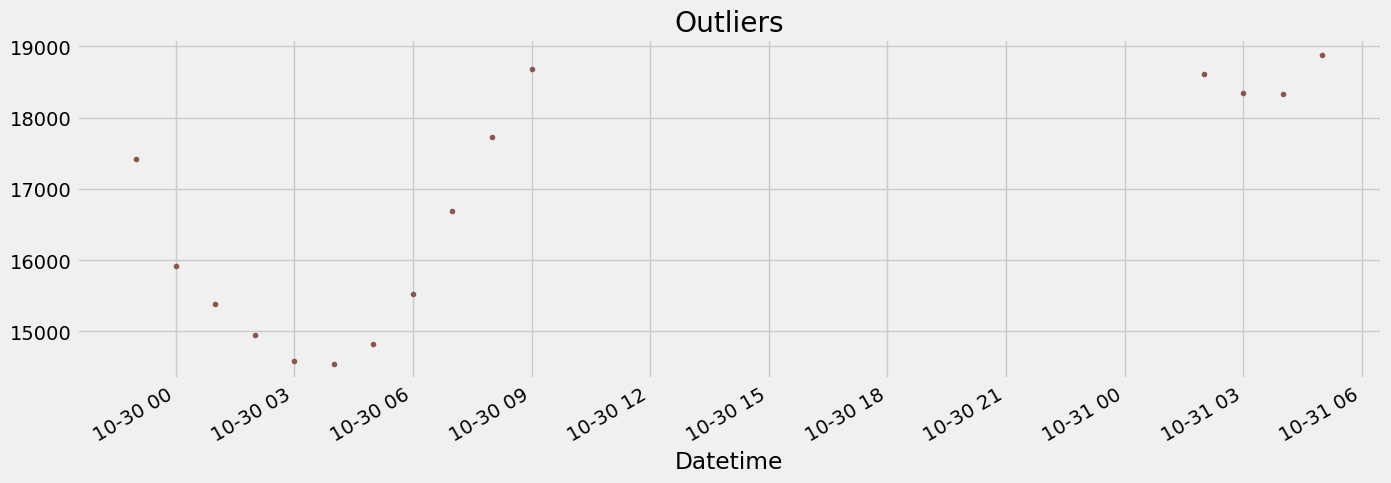

In [31]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [32]:
df = df.query('PJME_MW > 19_000').copy()

## Time Series Cross Validation

The traditional k-fold cross-validation approach is not suitable for time series data because it assumes that the data is independently and identically distributed, which is not true for time series data. 
- Instead, we need to use a modified form of cross-validation that takes into account the temporal dependencies in the data.

In [33]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=0)
df = df.sort_index()

In [34]:
tss.split(df)

<generator object TimeSeriesSplit.split at 0x7f83fff62eb0>

It is generator ...

In [35]:
iterator = iter(tss.split(df))
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 101554 101555 101556]
[101557 101558 101559 ... 110314 110315 110316]


In [36]:
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 110314 110315 110316]
[110317 110318 110319 ... 119074 119075 119076]


In [37]:
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 119074 119075 119076]
[119077 119078 119079 ... 127834 127835 127836]


It is clearer in a graphical representation

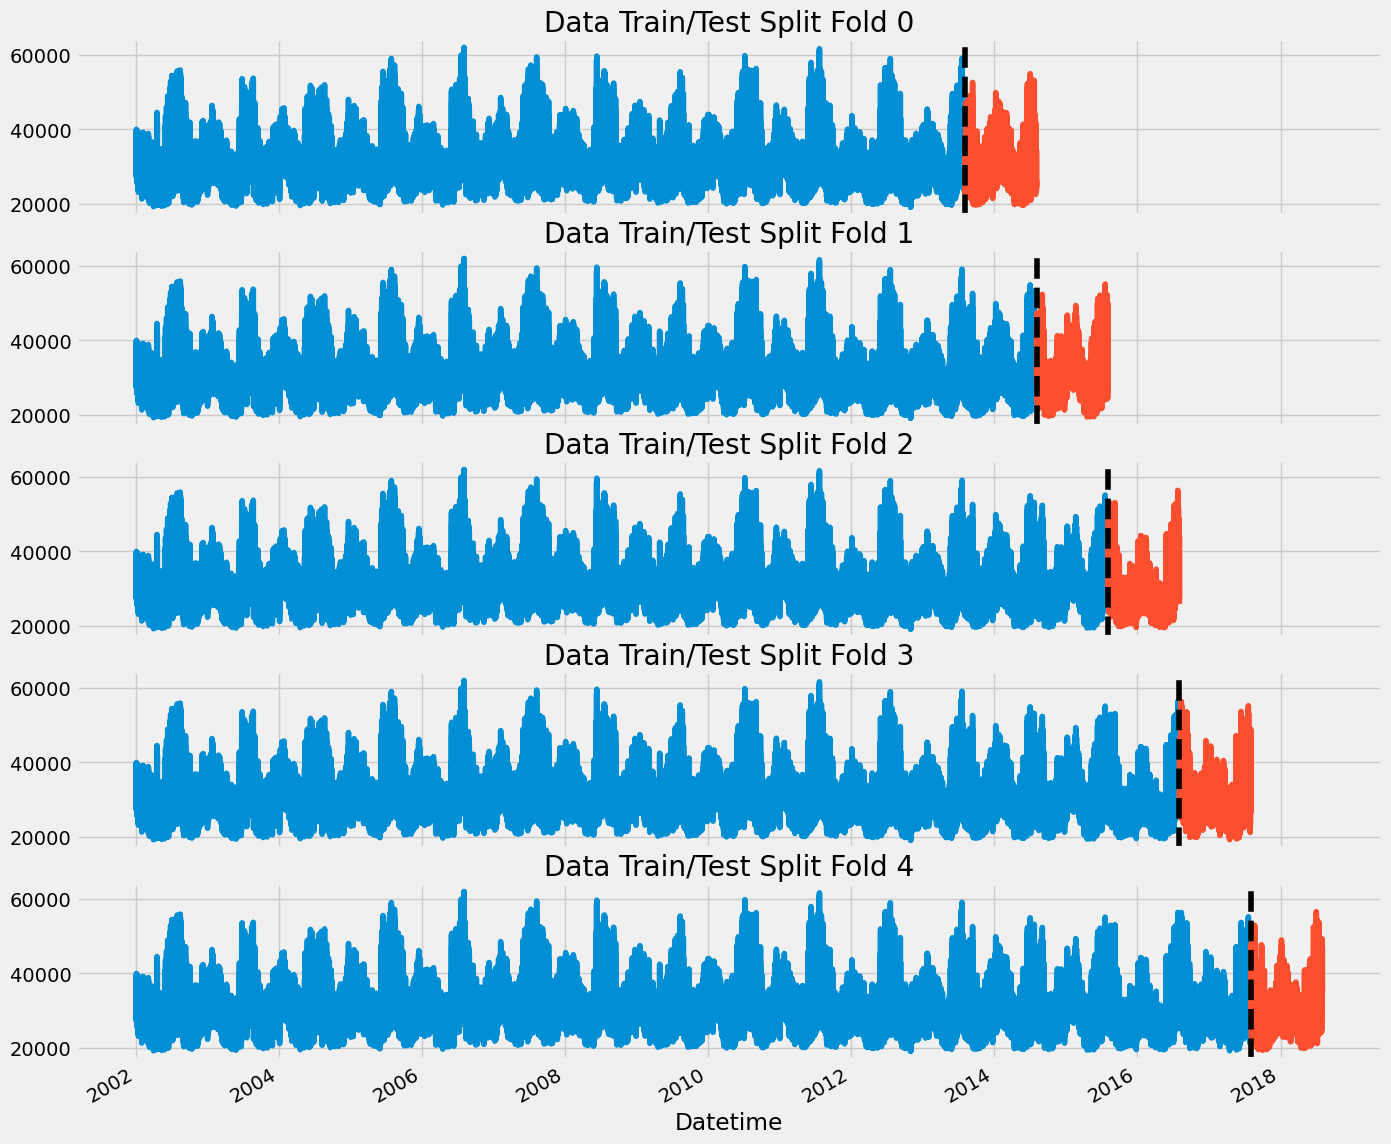

In [38]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Forecasting Horizon

The forecast horizon is the length of time into the future for which forecasts are to be prepared. 
- These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

## Lag Features

In time series analysis, lag features are variables that represent past values of the time series variable being analyzed. 
- Lag features are used to capture the autocorrelation or dependency of the time series variable on its past values.

In [39]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

add_lags(df)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,40968.414062,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,40544.871094,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,38946.386719,39525.0,38698.0,37330.0


In [40]:
df[df.index > '2010-01-01'][['PJME_MW','lag1', 'lag2', 'lag3']].head()

,PJME_MW,lag1,lag2,lag3
Datetime,,,,
2010-01-01 01:00:00,30075.0,31630.0,35291.0,26152.0
2010-01-01 02:00:00,28907.0,30500.0,34450.0,25030.0
2010-01-01 03:00:00,27906.0,29880.0,34217.0,24449.0
2010-01-01 04:00:00,27373.0,29682.0,34318.0,24230.0
2010-01-01 05:00:00,27411.0,30072.0,35032.0,24701.0


## Using Lags and Cross Validation together

In [41]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[10:45:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.30381	validation_1-rmse:31956.18912
[100]	validation_0-rmse:12532.08851	validation_1-rmse:11907.28743
[200]	validation_0-rmse:5743.63141	validation_1-rmse:5355.87526
[300]	validation_0-rmse:3866.68176	validation_1-rmse:3890.94882
[400]	validation_0-rmse:3429.68951	validation_1-rmse:3752.67972
[450]	validation_0-rmse:3355.70585	validation_1-rmse:3759.35636
[10:45:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.76435	validation_1-rmse:32142.13257
[100]	validation_0-rmse:12513.14073	validation_1-rmse:12225.51268
[200]	validation_0-rmse:5755.09841	validation_1-rmse:5651.50008
[300]	validation_0-rmse:3906.44526	validation_1-rmse:3935.00246
[400]	validation_0-rmse:3477.03202	validation_1-rmse:3601.93393
[500]	validation_0-rmse:3355.81430	validation_1-rmse:3

In [42]:
scores

[3752.67972535384,
 3439.9797410456126,
 3473.335331082484,
 4089.393008070547,
 3993.8801185144675]

In [43]:
np.mean(scores)

3749.8535848133906

Lets see the importance of the lag features for the last regressor

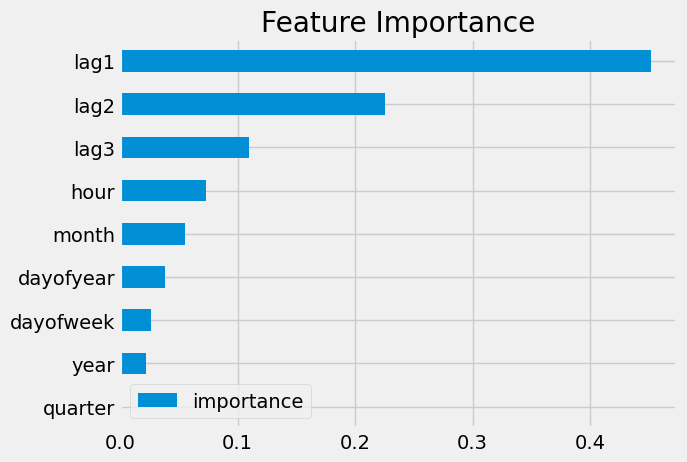

In [44]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<Axes: xlabel='Datetime'>

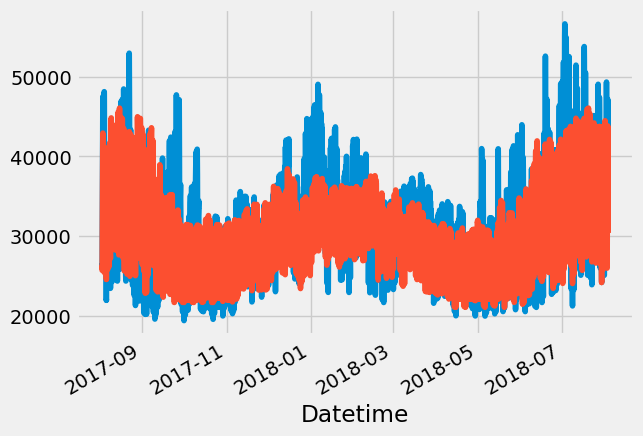

In [45]:
test['prediction'] = y_pred
test.PJME_MW.plot()
test.prediction.plot()

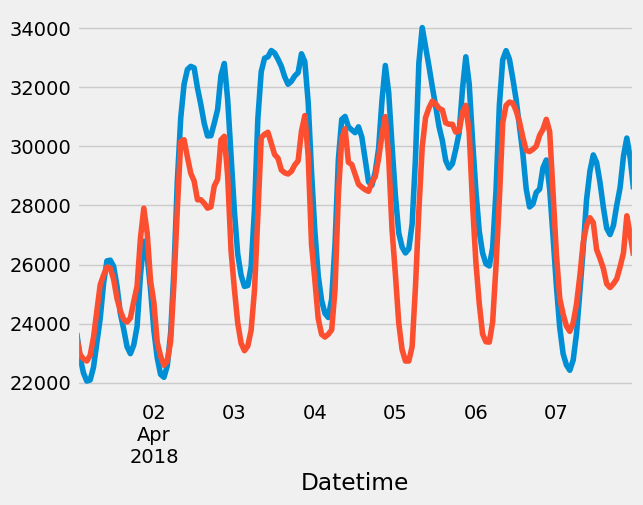

In [46]:
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')].PJME_MW.plot()
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')].prediction.plot()
plt.show()

## Predicting the Future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation